# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [80]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [81]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [82]:
from keras.datasets import mnist

# Загружаем датасет
(x_train0, y_train), (x_test0, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train0, np.float32), np.array(x_test0, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [83]:
x_train0.shape

(60000, 28, 28)

In [84]:
x_train0[0].shape, x_train0[0]

((28, 28),
 array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
 

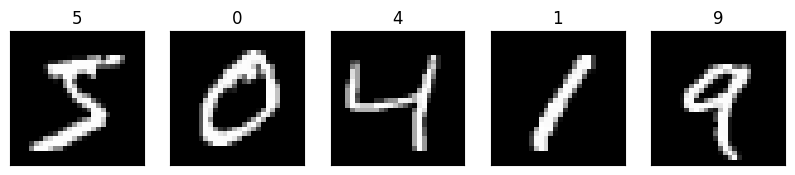

In [85]:
# Display some images
fig, axes = plt.subplots(ncols=5, sharex=False,
    sharey=True, figsize=(10, 4))
for i in range(5):
    axes[i].set_title(y_train[i])
    axes[i].imshow(x_train0[i], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

In [86]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w=tf.Variable(
            tf.random.normal([in_features, out_features]), name='w'
        )
        self.b=tf.Variable(tf.zeros([out_features]), name='b')

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation !=0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1=DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2=DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    self.layer_3=DenseLayer(in_features=n_hidden_2, out_features=10)

  def __call__(self, x):
    x1=self.layer_1(x)
    x2=self.layer_2(x1)
    x3=self.layer_3(x2, activation=1)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    return x3

In [87]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [88]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")
#print(neural_net.layer_1.trainable_variables)

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    opt_param=[neural_net.layer_1.trainable_variables, neural_net.layer_2.trainable_variables, neural_net.layer_3.trainable_variables]
    #trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    df1,df2,df3 = g.gradient(loss,opt_param)
    #gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    #optimizer.apply_gradients(zip(gradients, trainable_variables))
    neural_net.layer_1.b.assign_sub(learning_rate*df1[0])
    neural_net.layer_1.w.assign_sub(learning_rate*df1[1])

    neural_net.layer_2.b.assign_sub(learning_rate*df2[0])
    neural_net.layer_2.w.assign_sub(learning_rate*df2[1])

    neural_net.layer_3.b.assign_sub(learning_rate*df3[0])
    neural_net.layer_3.w.assign_sub(learning_rate*df3[1])


In [89]:
from numpy.lib.function_base import append
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in zip(range(training_steps), train_data.take(training_steps)): # Место для вашего кода:
    #enumerate(train_data.take(training_steps))
    # Обновляем веса нейронной сети
    train(neural_net,batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss=cross_entropy(y_pred=pred, y_true=batch_y)
        loss_history.append(loss)
        accur=accuracy(y_pred=pred, y_true=batch_y)
        accuracy_history.append(accur)
        print(f' step:{step}, loss: {loss}, accuracy: {accur}')
        # Место для вашего кода

 step:0, loss: 2723.3291015625, accuracy: 0.15625
 step:100, loss: 286.17633056640625, accuracy: 0.70703125
 step:200, loss: 205.98043823242188, accuracy: 0.765625
 step:300, loss: 184.60047912597656, accuracy: 0.8515625
 step:400, loss: 175.10958862304688, accuracy: 0.8046875
 step:500, loss: 137.26876831054688, accuracy: 0.8515625
 step:600, loss: 142.1764678955078, accuracy: 0.8828125
 step:700, loss: 107.65892028808594, accuracy: 0.89453125
 step:800, loss: 90.77903747558594, accuracy: 0.88671875
 step:900, loss: 103.13572692871094, accuracy: 0.87109375
 step:1000, loss: 65.34039306640625, accuracy: 0.921875
 step:1100, loss: 90.93415069580078, accuracy: 0.890625
 step:1200, loss: 65.21871185302734, accuracy: 0.91796875
 step:1300, loss: 97.85014343261719, accuracy: 0.890625
 step:1400, loss: 86.4612045288086, accuracy: 0.91015625
 step:1500, loss: 102.04373168945312, accuracy: 0.875
 step:1600, loss: 82.22538757324219, accuracy: 0.8984375
 step:1700, loss: 63.79509735107422, accur

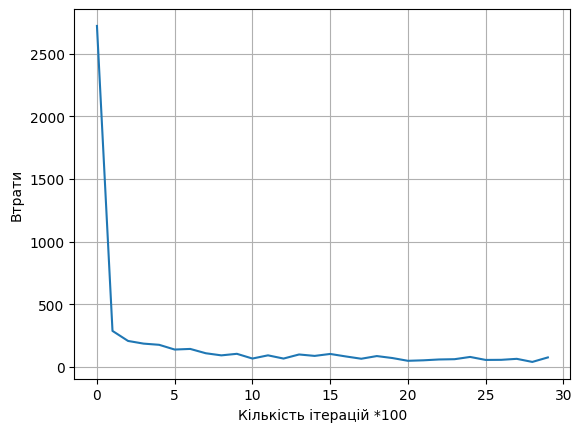

In [90]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
plt.plot(loss_history)
plt.grid()
plt.xlabel('Кількість ітерацій *100')
plt.ylabel('Втрати')
plt.show()
# Место для вашего кода

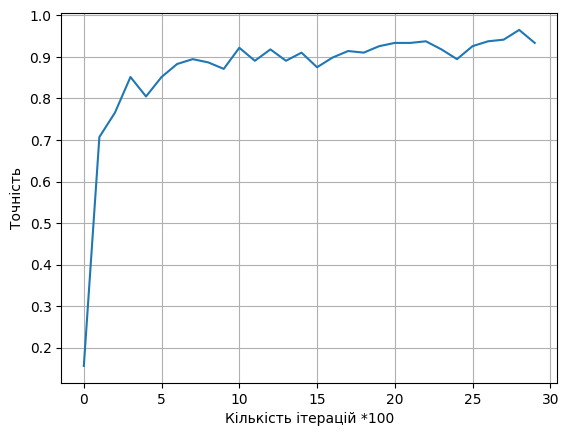

In [91]:
plt.plot(accuracy_history)
plt.grid()
plt.xlabel('Кількість ітерацій *100')
plt.ylabel('Точність')
plt.show()

In [92]:
# Вычислите точность обученной нейросети
y_pred2=neural_net(x_test)
print(f' Точність мережі : {accuracy(y_pred=y_pred2, y_true=y_test)*100}%')

 Точність мережі : 90.36000061035156%


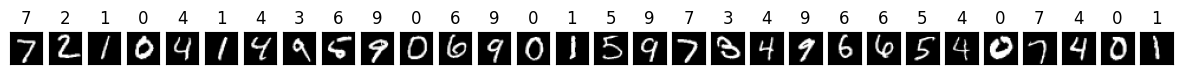

In [110]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Display some images
fig, axes = plt.subplots(ncols=30, sharex=False,
    sharey=True, figsize=(15, 6))
for i in range(30):
    axes[i].set_title(np.argmax(y_pred2[i]))
    axes[i].imshow(x_test0[i], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

Висновки: з наведенних картинок, максимальна помилка в мережі є одна картинка з 10 картинок.